## GED conflict data clean up

In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
#import the ingester extension functions
from ingester3.scratch import cache_manager
cache_manager()
from ingester3.extensions import *

import viewser
from viewser import Queryset, Column
from views_transformation_library import utilities

import ingester3
from ingester3.Country import Country

Clearing Secondary Cache...


In [3]:
# Show a list of available transforms
!viewser transforms list


  > Transforms
  ---------------------------------------------------------
  | name           | path                               |
  |:---------------|:-----------------------------------|
  | rename         | any/util.rename                    |
  | ln             | any/ops.ln                         |
  | gte            | any/bool.gte                       |
  | lte            | any/bool.lte                       |
  | in_range       | any/bool.in_range                  |
  | delta          | any/temporal.delta                 |
  | tlag           | any/temporal.tlag                  |
  | tlead          | any/temporal.tlead                 |
  | moving_average | any/temporal.moving_average        |
  | moving_sum     | any/temporal.moving_sum            |
  | cweq           | any/temporal.cweq                  |
  | time_since     | any/temporal.time_since            |
  | decay          | any/temporal.decay                 |
  | onset_possible | any/temporal.onset_possible      

In [4]:
!viewser tables show ged2_cm    


  > Ged2_cm
  -------------------------------------------------------
  | name                    | path                    |
  |:------------------------|:------------------------|
  | country_month_id        | country_month_id        |
  | ged_sb_best_sum_nokgi   | ged_sb_best_sum_nokgi   |
  | ged_ns_best_sum_nokgi   | ged_ns_best_sum_nokgi   |
  | ged_os_best_sum_nokgi   | ged_os_best_sum_nokgi   |
  | ged_sb_best_count_nokgi | ged_sb_best_count_nokgi |
  | ged_ns_best_count_nokgi | ged_ns_best_count_nokgi |
  | ged_os_best_count_nokgi | ged_os_best_count_nokgi |
  | ged_sb_high_sum_nokgi   | ged_sb_high_sum_nokgi   |
  | ged_ns_high_sum_nokgi   | ged_ns_high_sum_nokgi   |
  | ged_os_high_sum_nokgi   | ged_os_high_sum_nokgi   |
  | ged_sb_high_count_nokgi | ged_sb_high_count_nokgi |
  | ged_ns_high_count_nokgi | ged_ns_high_count_nokgi |
  | ged_os_high_count_nokgi | ged_os_high_count_nokgi |
  | test                    | test                    |
  
  ----------------------------

In [5]:
#get the ged with countrylags to indicate conflict in neighbouring countries
data_conflict = (Queryset("ged2_cm", "country_month")
                 .with_column(Column("ged_best_sb", from_table="ged2_cm", from_column="ged_sb_best_count_nokgi")
                 .transform.spatial.countrylag(1,1,0,0))
                 .with_column(Column("ged_best_ns", from_table="ged2_cm", from_column="ged_ns_best_count_nokgi")
                 .transform.spatial.countrylag(1,1,0,0))
                 .with_column(Column("ged_best_os", from_table="ged2_cm", from_column="ged_os_best_count_nokgi")
                 .transform.spatial.countrylag(1,1,0,0)))


data_conflict = data_conflict.publish().fetch()

data_conflict

 .      o      O      O      o

ged_best_sb  ged_best_ns  ged_best_os
month_id country_id                                       
1        1                   NaN          NaN          NaN
         2                   NaN          NaN          NaN
         3                   0.0          0.0          0.0
         4                   NaN          NaN          NaN
         5                   0.0          0.0          0.0
...                          ...          ...          ...
852      242                 0.0          0.0          0.0
         243                 0.0          0.0          0.0
         244                 0.0          0.0          0.0
         245                 0.0          0.0          0.0
         246                 0.0          0.0          0.0

[158230 rows x 3 columns]

In [6]:
#check for the distribution of 0 and 1
data_conflict.describe()

,ged_best_sb,ged_best_ns,ged_best_os
count,132206.000000,132206.000000,132206.000000
mean,8.720799,1.378992,1.858811
std,61.663374,11.258221,9.426434
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
max,2017.000000,414.000000,1107.000000


/Users/NatStrom/opt/miniconda3/envs/viewser/lib/python3.9/site-packages/seaborn/distributions.py:2142: UserWarning: `displot` is a figure-level function and does not accept the ax= parameter. You may wish to try histplot.
  warnings.warn(msg, UserWarning)
/Users/NatStrom/opt/miniconda3/envs/viewser/lib/python3.9/site-packages/seaborn/distributions.py:2142: UserWarning: `displot` is a figure-level function and does not accept the ax= parameter. You may wish to try histplot.
  warnings.warn(msg, UserWarning)
/Users/NatStrom/opt/miniconda3/envs/viewser/lib/python3.9/site-packages/seaborn/distributions.py:2142: UserWarning: `displot` is a figure-level function and does not accept the ax= parameter. You may wish to try histplot.
  warnings.warn(msg, UserWarning)


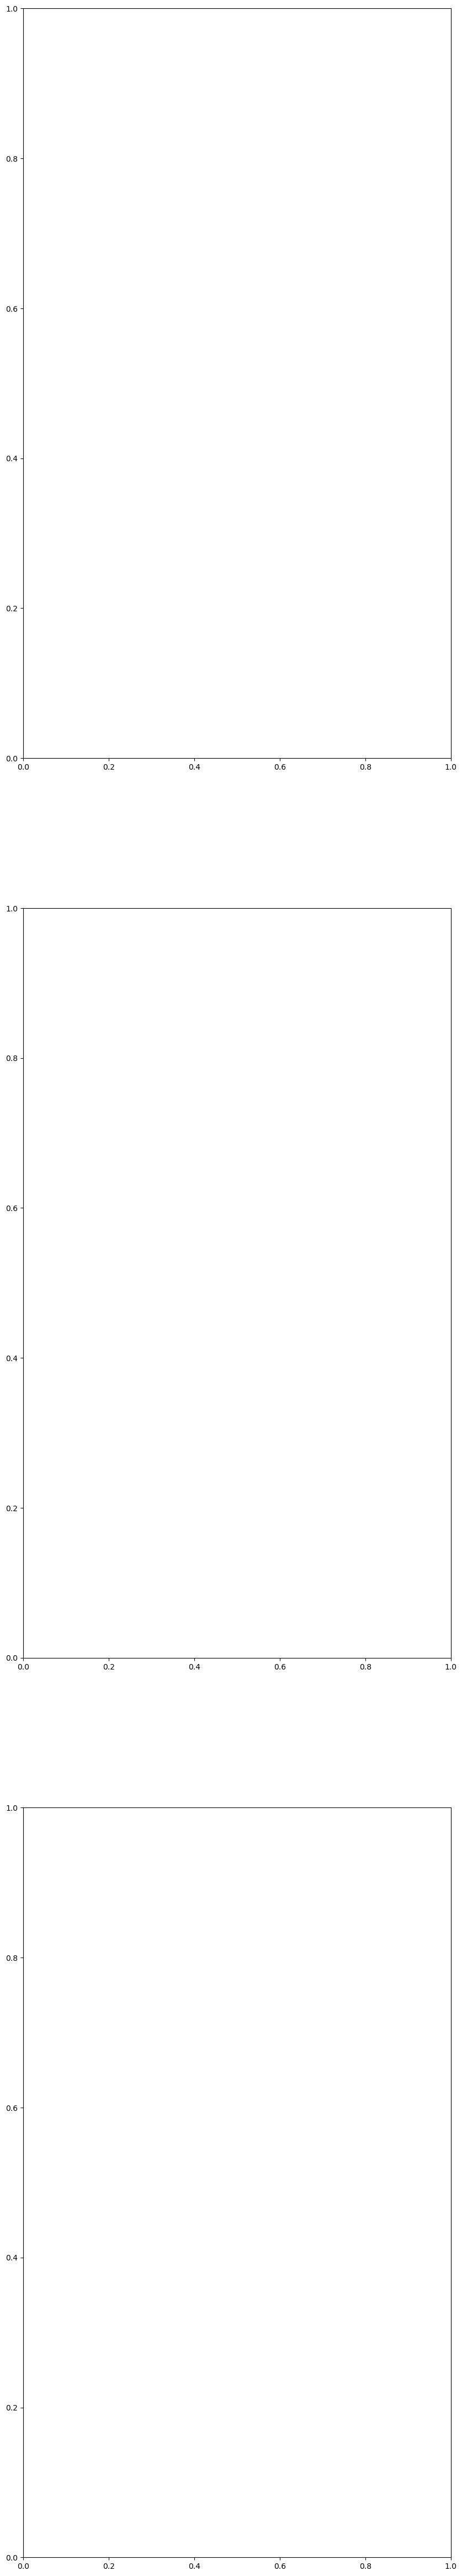

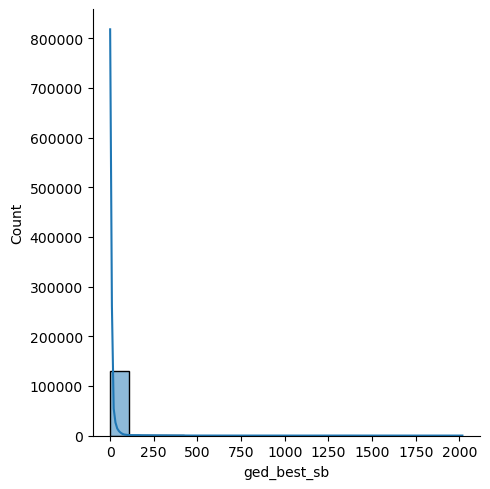

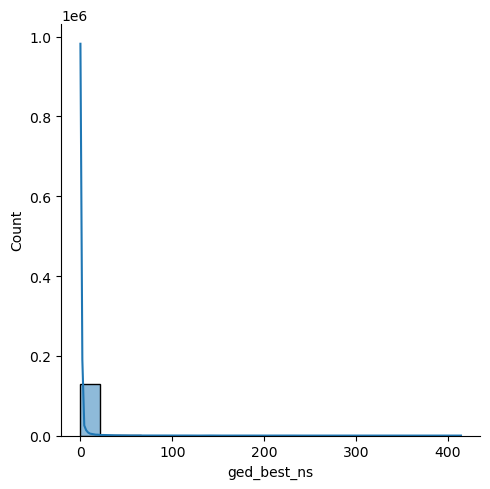

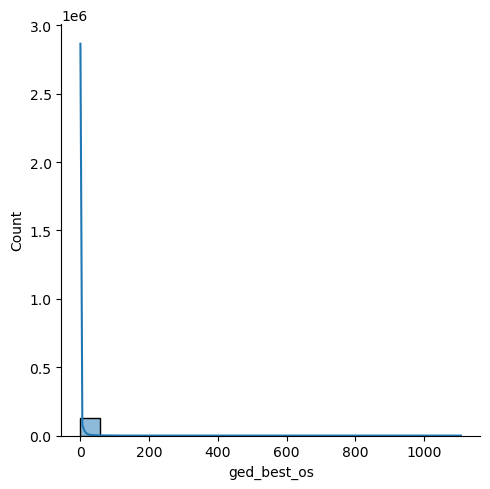

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure, axes = plt.subplots(3,1,figsize=(10,60))
sns.displot(data_conflict['ged_best_sb'],kde=True,ax=axes[0])
sns.displot(data_conflict['ged_best_ns'],kde=True,ax=axes[1])
sns.displot(data_conflict['ged_best_os'],kde=True,ax=axes[2])

In [8]:
#rename
data_conflict = data_conflict.rename(columns={'ged_best_sb':'best_sb_neighbor','ged_best_ns':'best_ns_neighbor','ged_best_os':'best_os_neighbor'})

In [9]:
#safe the data
data_conflict.to_csv('data_neighbor_conflict.csv')

## CUT HERE FOR MANUAL IMPORT

In [10]:
##set a working directory
user = os.path.expanduser('~')
display(user)

os.makedirs(f'{user}/Desktop/thesis/', exist_ok=True)
path = os.chdir(f'{user}/Desktop/'+'thesis/')

'/Users/NatStrom'

In [11]:
data = pd.read_csv('GEDEvent_v22_1.csv')

/var/folders/3l/pgxm2f9j3bbgbjcj2pyxl__00000gp/T/ipykernel_4036/2663555733.py:1: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('GEDEvent_v22_1.csv')


In [12]:
df = data.copy()

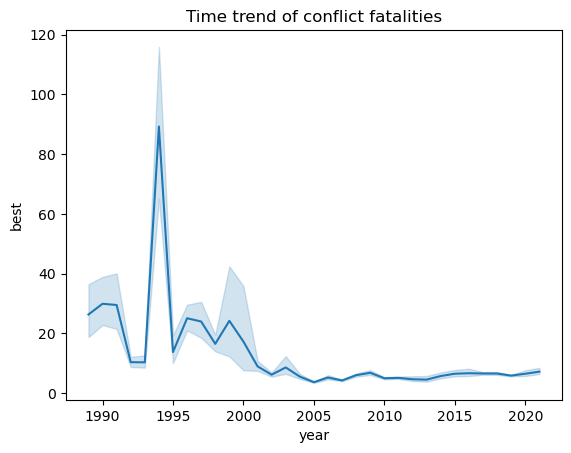

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.lineplot(x='year',y='best',data=df)
plt.title('Time trend of conflict fatalities')
plt.savefig('best_nolog.png')


In [14]:
print(df.dtypes)
print(df.columns)
print(df.describe(include='all'))

## sanity check to ensure the spread of the data is correct
print('sanity check 1, ensure appropriate years and countries are represented')
list_country=list(list(df['country_id'].drop_duplicates()))
list_year=list(list(df['year'].drop_duplicates()))
print('country list', list_country)
print('year list', list_year)
#inspect for NAs
print('following checks for completeness of all columns')
print(df['country_id'].isnull().values.any())

id                     int64
relid                 object
year                   int64
active_year            int64
code_status           object
type_of_violence       int64
conflict_dset_id       int64
conflict_new_id        int64
conflict_name         object
dyad_dset_id           int64
dyad_new_id            int64
dyad_name             object
side_a_dset_id         int64
side_a_new_id          int64
side_a                object
side_b_dset_id         int64
side_b_new_id          int64
side_b                object
number_of_sources      int64
source_article        object
source_office         object
source_date           object
source_headline       object
source_original       object
where_prec             int64
where_coordinates     object
where_description     object
adm_1                 object
adm_2                 object
latitude             float64
longitude            float64
geom_wkt              object
priogrid_gid           int64
country               object
country_id    

In [15]:
#filter only the wanted columns
df_filtered = df.filter(['id', 'relid', 'year', 'type_of_violence','conflict_new_id','country_id','best', 'high', 'low'])

In [16]:
display(df_filtered)

,id,relid,year,type_of_violence,conflict_new_id,country_id,best,high,low
0,244657,IRQ-2017-1-524-322,2017,1,259,700,6,6,6
1,412700,IRQ-2021-1-524-145,2021,1,259,700,183,184,171
2,413023,IRQ-2021-1-524-143,2021,1,259,700,2,3,0
3,412909,IRQ-2021-1-524-144,2021,1,259,700,10,10,9
4,132140,AFG-1989-1-411-2,1989,1,333,700,6,6,6
...,...,...,...,...,...,...,...,...,...
293629,15525,MZM-1989-3-1347-4,1989,3,562,552,9,9,9
293630,15524,MZM-1989-3-1347-16,1989,3,562,552,9,9,9
293631,15245,MZM-1990-3-1347-18,1990,3,562,552,7,7,7
293632,15516,MZM-1990-3-1347-28,1990,3,562,552,1,1,1


In [17]:
from ingester3.scratch import cache_manager

cache_manager()

# This will import the Pandas extensions as well as bootstrap the object layer
from ingester3.extensions import *

Clearing Secondary Cache...


In [18]:
#create the c_id from the gw codes
#create c_ids
df_filtered = pd.DataFrame.cy.soft_validate_gwcode_year(df_filtered, gw_col='country_id', year_col = 'year', at_month = 12)
inspect=df_filtered.query("valid_id == False")
print('countries with invalid id below')
display(inspect)

df_filtered = pd.DataFrame.c.from_gwcode(df_filtered, gw_col='country_id', month_col=None)

countries with invalid id below


,id,relid,year,type_of_violence,conflict_new_id,country_id,best,high,low,valid_id
138842,16107,SAF-1989-3-560-14,1989,3,477,565,0,300,0,False
138843,17748,SAF-1989-3-560-12,1989,3,477,565,0,27,0,False


In [20]:
#import the neighbor data
#transform month ids into year
data_conflict = data_conflict.reset_index()
data_conflict = data_conflict.rename(columns={'country_id':'c_id'})
data_conflict['year'] = data_conflict.cm.year
data_conflict

Clearing Secondary Cache...


,index,month_id,c_id,best_sb_neighbor,best_ns_neighbor,best_os_neighbor,year
0,0,1,1,NaN,NaN,NaN,1980
1,1,1,2,NaN,NaN,NaN,1980
2,2,1,3,0.0,0.0,0.0,1980
3,3,1,4,NaN,NaN,NaN,1980
4,4,1,5,0.0,0.0,0.0,1980
...,...,...,...,...,...,...,...
158225,158225,852,242,0.0,0.0,0.0,2050
158226,158226,852,243,0.0,0.0,0.0,2050
158227,158227,852,244,0.0,0.0,0.0,2050
158228,158228,852,245,0.0,0.0,0.0,2050


In [21]:
data_conflict = data_conflict.groupby(['year','c_id']).sum()
data_conflict['best_neighbor']=data_conflict['best_sb_neighbor'] + data_conflict['best_os_neighbor'] + data_conflict['best_ns_neighbor']

In [23]:
#sum up to create a dummy for neighboring country in conflict or not
def categorize(column):  
    if column['best_neighbor'] >= 25:
        return 1
    return 0

data_conflict['dummy_neighbor_hightreshold'] = data_conflict.apply(lambda row: categorize(row), axis=1)
data_conflict

index  month_id  best_sb_neighbor  best_ns_neighbor  \
year c_id                                                          
1980 1       10581        78               0.0               0.0   
     2       10593        78               0.0               0.0   
     3       10605        78               0.0               0.0   
     4       10617        78               0.0               0.0   
     5       10629        78               0.0               0.0   
...            ...       ...               ...               ...   
2050 242   1886094     10158               0.0               0.0   
     243   1886106     10158               0.0               0.0   
     244   1886118     10158               0.0               0.0   
     245   1886130     10158               0.0               0.0   
     246   1886142     10158               0.0               0.0   

           best_os_neighbor  best_neighbor  dummy_neighbor_hightreshold  
year c_id                                                                
1980 1                  0.0            0.0                            0  
     2                  0.0            0.0                            0  
     3                  0.0            0.0                            0  
     4                  0.0            0.0                            0  
     5                  0.0            0.0                            0  
...                     ...            ...                          ...  
2050 242                0.0            0.0                            0  
     243                0.0            0.0                            0  
     244                0.0            0.0                            0  
     245                0.0            0.0                            0  
     246                0.0            0.0                            0  

[13223 rows x 7 columns]

In [25]:
#sum up to create a dummy for neighboring country in conflict or not
def categorize(column):  
    if column['best_neighbor'] >= 1:
        return 1
    return 0

data_conflict['dummy_neighbor'] = data_conflict.apply(lambda row: categorize(row), axis=1)
data_conflict

index  month_id  best_sb_neighbor  best_ns_neighbor  \
year c_id                                                          
1980 1       10581        78               0.0               0.0   
     2       10593        78               0.0               0.0   
     3       10605        78               0.0               0.0   
     4       10617        78               0.0               0.0   
     5       10629        78               0.0               0.0   
...            ...       ...               ...               ...   
2050 242   1886094     10158               0.0               0.0   
     243   1886106     10158               0.0               0.0   
     244   1886118     10158               0.0               0.0   
     245   1886130     10158               0.0               0.0   
     246   1886142     10158               0.0               0.0   

           best_os_neighbor  best_neighbor  dummy_neighbor_hightreshold  \
year c_id                                                                 
1980 1                  0.0            0.0                            0   
     2                  0.0            0.0                            0   
     3                  0.0            0.0                            0   
     4                  0.0            0.0                            0   
     5                  0.0            0.0                            0   
...                     ...            ...                          ...   
2050 242                0.0            0.0                            0   
     243                0.0            0.0                            0   
     244                0.0            0.0                            0   
     245                0.0            0.0                            0   
     246                0.0            0.0                            0   

           dummy_neighbor  
year c_id                  
1980 1                  0  
     2                  0  
     3                  0  
     4                  0  
     5                  0  
...                   ...  
2050 242                0  
     243                0  
     244                0  
     245                0  
     246                0  

[13223 rows x 8 columns]

In [26]:
data_conflict = data_conflict.reset_index()
data_conflict = data_conflict.drop(columns=['month_id','best_sb_neighbor','best_ns_neighbor','best_os_neighbor','best_neighbor'])

In [27]:
#join with the nbeighbouring conflict country data
display(data_conflict)
df_filtered = pd.merge(df_filtered,data_conflict,how='outer',on=('c_id','year'))

,year,c_id,index,dummy_neighbor_hightreshold,dummy_neighbor
0,1980,1,10581,0,0
1,1980,2,10593,0,0
2,1980,3,10605,0,0
3,1980,4,10617,0,0
4,1980,5,10629,0,0
...,...,...,...,...,...
13218,2050,242,1886094,0,0
13219,2050,243,1886106,0,0
13220,2050,244,1886118,0,0
13221,2050,245,1886130,0,0


In [28]:
df_filtered['Africa'] = df_filtered.c.in_africa

Clearing Secondary Cache...


In [29]:
df_filtered = df_filtered.query('Africa == True')

In [30]:
#get the iso numbers
df_filtered['iso'] = df_filtered.c.isoab

Clearing Secondary Cache...


In [31]:
inspect = df_filtered.loc[df_filtered.iso.isna()]
display(inspect)

,id,relid,year,type_of_violence,conflict_new_id,country_id,best,high,low,valid_id,c_id,index,dummy_neighbor_hightreshold,dummy_neighbor,Africa,iso


In [32]:
df_conflict = df_filtered.copy()

In [33]:
df_conflict

,id,relid,year,type_of_violence,conflict_new_id,country_id,best,high,low,valid_id,c_id,index,dummy_neighbor_hightreshold,dummy_neighbor,Africa,iso
41447,2629.0,ALG-1990-1-2-1,1990,1.0,386.0,615.0,1.0,1.0,1.0,True,67,248615.0,0.0,1.0,True,DZA
41448,5751.0,ALG-1991-1-2-4,1991,1.0,386.0,615.0,3.0,3.0,3.0,True,67,272685.0,0.0,1.0,True,DZA
41449,2587.0,ALG-1991-1-2-1,1991,1.0,386.0,615.0,4.0,4.0,4.0,True,67,272685.0,0.0,1.0,True,DZA
41450,4216.0,ALG-1991-1-2-2,1991,1.0,386.0,615.0,10.0,10.0,10.0,True,67,272685.0,0.0,1.0,True,DZA
41451,3160.0,ALG-1991-1-2-3,1991,1.0,386.0,615.0,17.0,17.0,17.0,True,67,272685.0,0.0,1.0,True,DZA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305072,NaN,NaN,2050,NaN,NaN,NaN,NaN,NaN,NaN,NaN,242,1886094.0,0.0,0.0,True,TZA
305073,NaN,NaN,2050,NaN,NaN,NaN,NaN,NaN,NaN,NaN,243,1886106.0,0.0,0.0,True,MAR
305074,NaN,NaN,2050,NaN,NaN,NaN,NaN,NaN,NaN,NaN,244,1886118.0,0.0,0.0,True,MRT
305075,NaN,NaN,2050,NaN,NaN,NaN,NaN,NaN,NaN,NaN,245,1886130.0,0.0,0.0,True,SDN


In [34]:
df_conflict = df_conflict.drop(columns=['valid_id','Africa','c_id','relid','conflict_new_id','country_id','id'])
df_conflict

,year,type_of_violence,best,high,low,index,dummy_neighbor_hightreshold,dummy_neighbor,iso
41447,1990,1.0,1.0,1.0,1.0,248615.0,0.0,1.0,DZA
41448,1991,1.0,3.0,3.0,3.0,272685.0,0.0,1.0,DZA
41449,1991,1.0,4.0,4.0,4.0,272685.0,0.0,1.0,DZA
41450,1991,1.0,10.0,10.0,10.0,272685.0,0.0,1.0,DZA
41451,1991,1.0,17.0,17.0,17.0,272685.0,0.0,1.0,DZA
...,...,...,...,...,...,...,...,...,...
305072,2050,NaN,NaN,NaN,NaN,1886094.0,0.0,0.0,TZA
305073,2050,NaN,NaN,NaN,NaN,1886106.0,0.0,0.0,MAR
305074,2050,NaN,NaN,NaN,NaN,1886118.0,0.0,0.0,MRT
305075,2050,NaN,NaN,NaN,NaN,1886130.0,0.0,0.0,SDN


In [35]:
#make a binary predictor of it --> conflict or not and then also high conflict or not, low conflict or not etc
#create dummies
def categorize(row):  
    if row['best'] >= 25 :
        return 1
    return 0

df_conflict['dummy_conflict_hightreshold'] = df_conflict.apply(lambda row: categorize(row), axis=1)
df_conflict

,year,type_of_violence,best,high,low,index,dummy_neighbor_hightreshold,dummy_neighbor,iso,dummy_conflict_hightreshold
41447,1990,1.0,1.0,1.0,1.0,248615.0,0.0,1.0,DZA,0
41448,1991,1.0,3.0,3.0,3.0,272685.0,0.0,1.0,DZA,0
41449,1991,1.0,4.0,4.0,4.0,272685.0,0.0,1.0,DZA,0
41450,1991,1.0,10.0,10.0,10.0,272685.0,0.0,1.0,DZA,0
41451,1991,1.0,17.0,17.0,17.0,272685.0,0.0,1.0,DZA,0
...,...,...,...,...,...,...,...,...,...,...
305072,2050,NaN,NaN,NaN,NaN,1886094.0,0.0,0.0,TZA,0
305073,2050,NaN,NaN,NaN,NaN,1886106.0,0.0,0.0,MAR,0
305074,2050,NaN,NaN,NaN,NaN,1886118.0,0.0,0.0,MRT,0
305075,2050,NaN,NaN,NaN,NaN,1886130.0,0.0,0.0,SDN,0


In [36]:
#make a binary predictor of it --> conflict or not and then also high conflict or not, low conflict or not etc
#create dummies
def categorize(row):  
    if row['best'] >= 1 :
        return 1
    return 0

df_conflict['dummy_conflict'] = df_conflict.apply(lambda row: categorize(row), axis=1)
df_conflict

,year,type_of_violence,best,high,low,index,dummy_neighbor_hightreshold,dummy_neighbor,iso,dummy_conflict_hightreshold,dummy_conflict
41447,1990,1.0,1.0,1.0,1.0,248615.0,0.0,1.0,DZA,0,1
41448,1991,1.0,3.0,3.0,3.0,272685.0,0.0,1.0,DZA,0,1
41449,1991,1.0,4.0,4.0,4.0,272685.0,0.0,1.0,DZA,0,1
41450,1991,1.0,10.0,10.0,10.0,272685.0,0.0,1.0,DZA,0,1
41451,1991,1.0,17.0,17.0,17.0,272685.0,0.0,1.0,DZA,0,1
...,...,...,...,...,...,...,...,...,...,...,...
305072,2050,NaN,NaN,NaN,NaN,1886094.0,0.0,0.0,TZA,0,0
305073,2050,NaN,NaN,NaN,NaN,1886106.0,0.0,0.0,MAR,0,0
305074,2050,NaN,NaN,NaN,NaN,1886118.0,0.0,0.0,MRT,0,0
305075,2050,NaN,NaN,NaN,NaN,1886130.0,0.0,0.0,SDN,0,0


In [37]:
#replace row values
df_conflict['type_of_violence'] = df_conflict['type_of_violence'].map({1:'sb',
                                            2:'ns',
                                            3:'os'})

In [38]:
#create dummies
def categorize(row):  
    if row['type_of_violence'] == 'sb':
        return 1
    return 0

df_conflict['dummy_sb'] = df_conflict.apply(lambda row: categorize(row), axis=1)

# repeat for non-state violence
def categorize(row):  
    if row['type_of_violence'] == 'ns':
        return 1
    return 0

df_conflict['dummy_ns'] = df_conflict.apply(lambda row: categorize(row), axis=1)

#repeat dummy creation for one-sided violence
def categorize(row):  
    if row['type_of_violence'] == 'os':
        return 1
    return 0

df_conflict['dummy_os'] = df_conflict.apply(lambda row: categorize(row), axis=1)



In [39]:
df_conflict.best.describe()

count    53989.000000
mean        25.644391
std        466.595365
min          0.000000
25%          1.000000
50%          3.000000
75%          8.000000
max      48183.000000
Name: best, dtype: float64

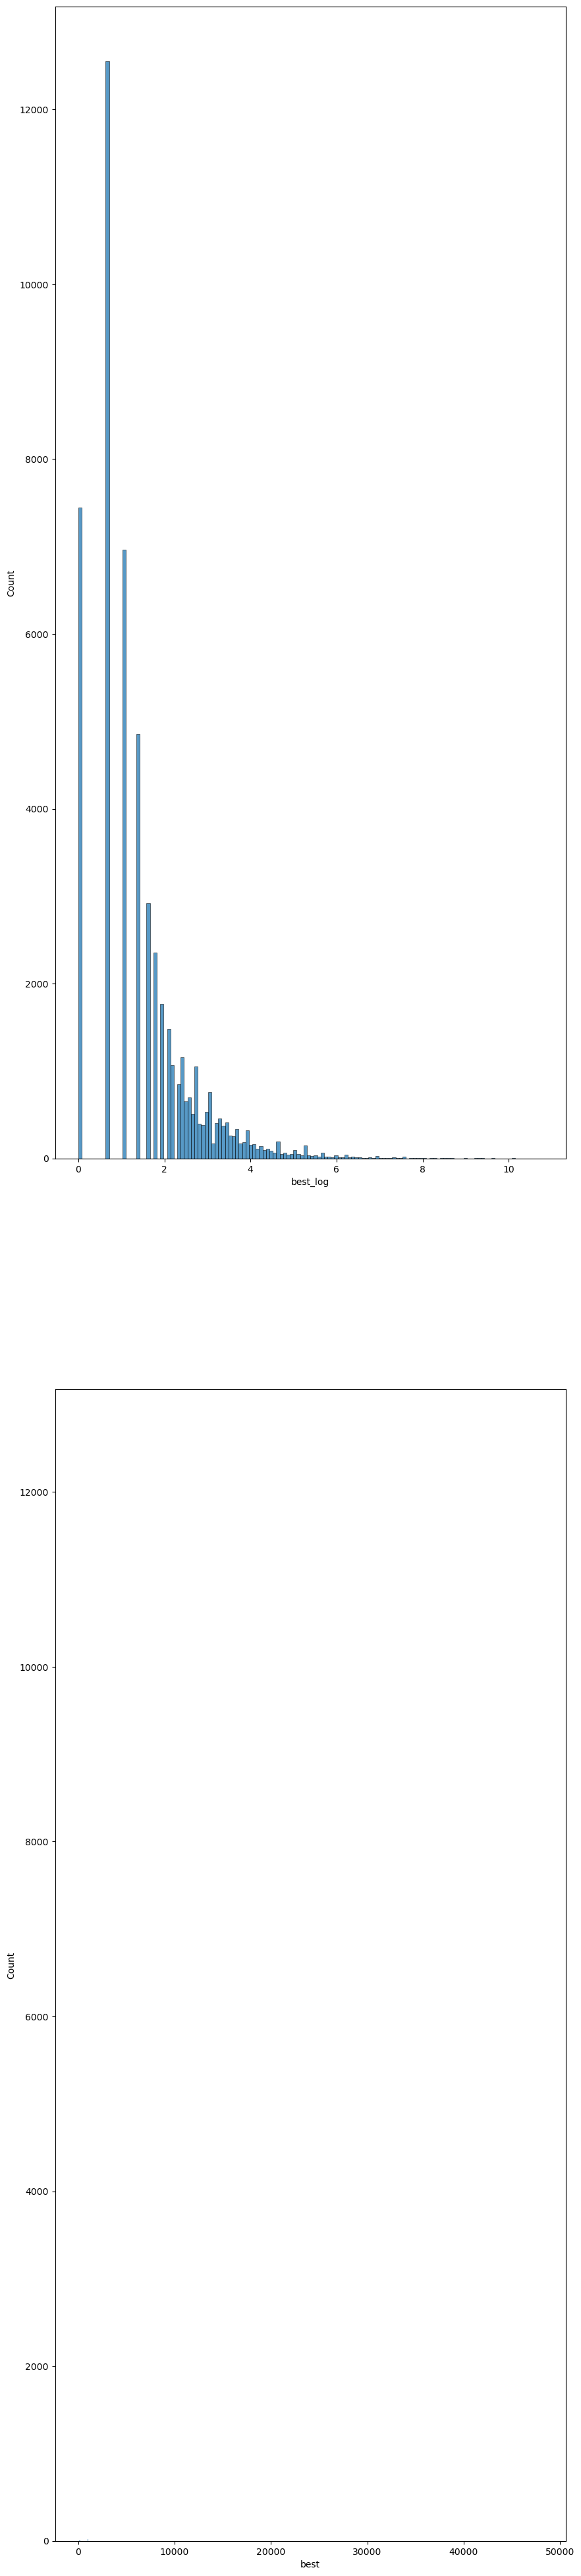

In [40]:
#now that all the zeros have been eliminated, log transfrom the best fatalities estimates
df_conflict['best_log'] = np.log1p(df_conflict['best'])
#compare skewed and logtransformed best
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
figure, axes = plt.subplots(2,1,figsize=(10,50))
sns.histplot(df_conflict['best_log'],ax=axes[0])
sns.histplot(df_conflict['best'],ax=axes[1])

plt.savefig('conflict_log.png')

In [41]:
#now produce the lags and filter out the unwanted years
#now I need to loop the lagging function, creating a new column and appending them all together to then have a dataframe i can concanate
df_conflict = df_conflict.loc[df_conflict['year'] <= 2019]
df_conflict['lag_best_5'] = df_conflict.groupby('iso')['best_log'].shift(5)
df_conflict['lag_best_10'] = df_conflict.groupby('iso')['best_log'].shift(10)
df_conflict['lag_best_20'] = df_conflict.groupby('iso')['best_log'].shift(20)
df_conflict = df_conflict.loc[df_conflict['year'] >= 1990]

df_conflict

,year,type_of_violence,best,high,low,index,dummy_neighbor_hightreshold,dummy_neighbor,iso,dummy_conflict_hightreshold,dummy_conflict,dummy_sb,dummy_ns,dummy_os,best_log,lag_best_5,lag_best_10,lag_best_20
41447,1990,sb,1.0,1.0,1.0,248615.0,0.0,1.0,DZA,0,1,1,0,0,0.693147,NaN,NaN,NaN
41448,1991,sb,3.0,3.0,3.0,272685.0,0.0,1.0,DZA,0,1,1,0,0,1.386294,NaN,NaN,NaN
41449,1991,sb,4.0,4.0,4.0,272685.0,0.0,1.0,DZA,0,1,1,0,0,1.609438,NaN,NaN,NaN
41450,1991,sb,10.0,10.0,10.0,272685.0,0.0,1.0,DZA,0,1,1,0,0,2.397895,NaN,NaN,NaN
41451,1991,sb,17.0,17.0,17.0,272685.0,0.0,1.0,DZA,0,1,1,0,0,2.890372,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299254,2019,NaN,NaN,NaN,NaN,1033098.0,0.0,1.0,NAM,0,0,0,0,0,NaN,NaN,NaN,NaN
299256,2019,NaN,NaN,NaN,NaN,1033134.0,0.0,0.0,MUS,0,0,0,0,0,NaN,NaN,NaN,NaN
299257,2019,NaN,NaN,NaN,NaN,1033146.0,0.0,0.0,SYC,0,0,0,0,0,NaN,NaN,NaN,NaN
299274,2019,NaN,NaN,NaN,NaN,1033482.0,0.0,1.0,MAR,0,0,0,0,0,NaN,NaN,NaN,NaN


In [42]:
df_conflict.columns

Index(['year', 'type_of_violence', 'best', 'high', 'low', 'index',
       'dummy_neighbor_hightreshold', 'dummy_neighbor', 'iso',
       'dummy_conflict_hightreshold', 'dummy_conflict', 'dummy_sb', 'dummy_ns',
       'dummy_os', 'best_log', 'lag_best_5', 'lag_best_10', 'lag_best_20'],
      dtype='object')

In [43]:
df_conflict = df_conflict.drop(columns=['type_of_violence', 'best', 'high', 'low'])
df_conflict

,year,index,dummy_neighbor_hightreshold,dummy_neighbor,iso,dummy_conflict_hightreshold,dummy_conflict,dummy_sb,dummy_ns,dummy_os,best_log,lag_best_5,lag_best_10,lag_best_20
41447,1990,248615.0,0.0,1.0,DZA,0,1,1,0,0,0.693147,NaN,NaN,NaN
41448,1991,272685.0,0.0,1.0,DZA,0,1,1,0,0,1.386294,NaN,NaN,NaN
41449,1991,272685.0,0.0,1.0,DZA,0,1,1,0,0,1.609438,NaN,NaN,NaN
41450,1991,272685.0,0.0,1.0,DZA,0,1,1,0,0,2.397895,NaN,NaN,NaN
41451,1991,272685.0,0.0,1.0,DZA,0,1,1,0,0,2.890372,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299254,2019,1033098.0,0.0,1.0,NAM,0,0,0,0,0,NaN,NaN,NaN,NaN
299256,2019,1033134.0,0.0,0.0,MUS,0,0,0,0,0,NaN,NaN,NaN,NaN
299257,2019,1033146.0,0.0,0.0,SYC,0,0,0,0,0,NaN,NaN,NaN,NaN
299274,2019,1033482.0,0.0,1.0,MAR,0,0,0,0,0,NaN,NaN,NaN,NaN


In [44]:
df_conflict.to_csv('df_conflict.csv')